In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


In [38]:
# Load the dataset

df = pd.read_csv('/content/Quote-Equity-M&M-EQ-04-02-2024-to-04-02-2025.csv')

# Display first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())


         Date  series      OPEN      HIGH       LOW  PREV. CLOSE       ltp   \
0  03-Feb-2025      EQ  3,056.60  3,187.95  3,044.75     3,076.75  3,169.00   
1  01-Feb-2025      EQ  2,990.00  3,098.95  2,990.00     2,989.85  3,069.85   
2  31-Jan-2025      EQ  2,970.00  3,049.85  2,955.10     2,971.45  3,000.00   
3  30-Jan-2025      EQ  2,924.35  3,008.90  2,919.00     2,924.35  2,972.00   
4  29-Jan-2025      EQ  2,883.95  2,933.50  2,856.30     2,870.60  2,933.50   

     close      vwap     52W H     52W L     VOLUME               VALUE   \
0  3,173.30  3,129.67  3,237.05  1,623.45  36,64,084  11,46,73,73,532.90   
1  3,076.75  3,052.90  3,237.05  1,609.05  26,74,573   8,16,52,08,918.35   
2  2,989.85  3,005.90  3,237.05  1,609.05  24,12,370   7,25,13,51,432.55   
3  2,971.45  2,970.94  3,237.05  1,609.05  30,55,352   9,07,72,52,819.00   
4  2,924.35  2,901.11  3,237.05  1,609.05  18,08,565   5,24,68,39,928.40   

  No of trades   
0      2,41,251  
1      1,52,464  
2      1,34,67

In [39]:
# Trim spaces from column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop any rows where 'Date' conversion failed
df = df.dropna(subset=['Date'])

# Sort the data by date
df = df.sort_values(by='Date')

print(df.head())  # Check if 'Date' column is properly formatted


          Date series      OPEN      HIGH       LOW PREV. CLOSE       ltp  \
249 2024-02-05     EQ  1,676.70  1,712.85  1,665.10    1,660.75  1,700.00   
248 2024-02-06     EQ  1,710.95  1,730.00  1,706.00    1,703.55  1,728.00   
247 2024-02-07     EQ  1,731.45  1,752.00  1,715.70    1,727.65  1,722.00   
246 2024-02-08     EQ  1,729.00  1,743.90  1,675.55    1,721.00  1,691.20   
245 2024-02-09     EQ  1,686.00  1,689.75  1,628.00    1,685.90  1,644.45   

        close      vwap     52W H     52W L     VOLUME              VALUE  \
249  1,703.55  1,697.06  1,758.00  1,123.40  35,25,423  5,98,28,67,697.00   
248  1,727.65  1,722.89  1,758.00  1,123.40  22,19,874  3,82,45,98,913.10   
247  1,721.00  1,727.35  1,758.00  1,123.40  12,13,661  2,09,64,13,185.25   
246  1,685.90  1,707.81  1,758.00  1,123.40  25,50,690  4,35,61,02,159.50   
245  1,646.40  1,647.76  1,758.00  1,123.40  20,33,950  3,35,14,65,286.60   

    No of trades  
249     1,49,948  
248     1,26,701  
247     1,11,960 

In [40]:
# Remove commas and convert 'Close' column to float
df['close'] = df['close'].str.replace(',', '', regex=True).astype(float)


In [41]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Select relevant features
df = df[['Date', 'close']]

# Normalize the closing prices
scaler = MinMaxScaler(feature_range=(0,1))
df['close'] = scaler.fit_transform(df[['close']])


In [47]:
# Split into training (70%) and testing (30%) sets
train_size = int(len(df) * 0.7)
train_data = df[:train_size]
test_data = df[train_size:]

# Convert 'Close' column to numpy array
train_array = train_data['close'].values.reshape(-1, 1)
test_array = test_data['close'].values.reshape(-1, 1)

# Debug: Check array shapes
print(f"Train data shape: {train_array.shape}")
print(f"Test data shape: {test_array.shape}")

# Adjust time_step if test set is too small
time_step = min(60, len(train_array) - 1, len(test_array) - 1)
print(f"Using time_step: {time_step}")

# Function to create sequences
def create_sequences(data, time_step):
    X, Y = [], []
    if len(data) <= time_step:  # Prevent index errors
        print("🚨 Not enough data for sequence creation! Reducing time_step.")
        return np.array([]), np.array([])
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Generate sequences
X_train, Y_train = create_sequences(train_array, time_step)
X_test, Y_test = create_sequences(test_array, time_step)

# Debug: Check sequence shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Ensure X_train and X_test are not empty before reshaping
if X_train.shape[0] > 0:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
if X_test.shape[0] > 0:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Debug: Confirm final shapes
print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


Train data shape: (175, 1)
Test data shape: (75, 1)
Using time_step: 60
X_train shape: (115, 60), Y_train shape: (115,)
X_test shape: (15, 60), Y_test shape: (15,)
Final X_train shape: (115, 60, 1)
Final X_test shape: (15, 60, 1)


In [48]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 0.5278 - val_loss: 0.1698
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0988 - val_loss: 0.0884
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0669 - val_loss: 0.0635
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0367 - val_loss: 0.0076
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0260 - val_loss: 0.0110
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0155 - val_loss: 0.0064
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0129 - val_loss: 0.0058
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0122 - val_loss: 0.0059
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0114 - val_loss: 0.0058
Epoch 13/50

In [49]:
# Predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform to original scale
train_pred = scaler.inverse_transform(train_pred)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_pred = scaler.inverse_transform(test_pred)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate errors
train_rmse = math.sqrt(mean_squared_error(Y_train_actual, train_pred))
test_rmse = math.sqrt(mean_squared_error(Y_test_actual, test_pred))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Training RMSE: 108.20554304515133
Testing RMSE: 122.70858364555637


Test Dates: 15, Actual Prices: 15, Predicted Prices: 15


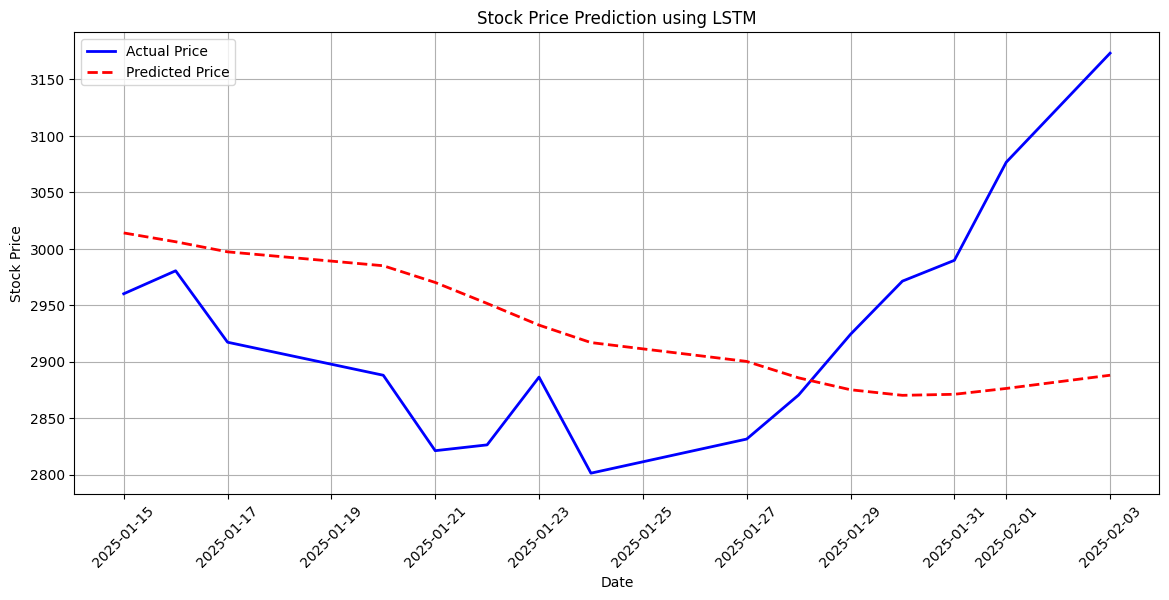

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Ensure 'Date' column is correctly formatted and aligned
test_dates = df['Date'].values[train_size + time_step:]

# Convert NumPy arrays to lists (fixes visualization issues)
Y_test_actual = Y_test_actual.flatten().tolist()
test_pred = test_pred.flatten().tolist()

# Check if lengths match, otherwise truncate to the smallest size
min_length = min(len(test_dates), len(Y_test_actual), len(test_pred))
test_dates = test_dates[:min_length]
Y_test_actual = Y_test_actual[:min_length]
test_pred = test_pred[:min_length]

# Debugging print statements
print(f"Test Dates: {len(test_dates)}, Actual Prices: {len(Y_test_actual)}, Predicted Prices: {len(test_pred)}")

# Plot actual vs predicted stock prices
plt.plot(test_dates, Y_test_actual, color='blue', label="Actual Price", linewidth=2)
plt.plot(test_dates, test_pred, color='red', linestyle="dashed", label="Predicted Price", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction using LSTM")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.grid(True)  # Adds a grid for better visibility
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


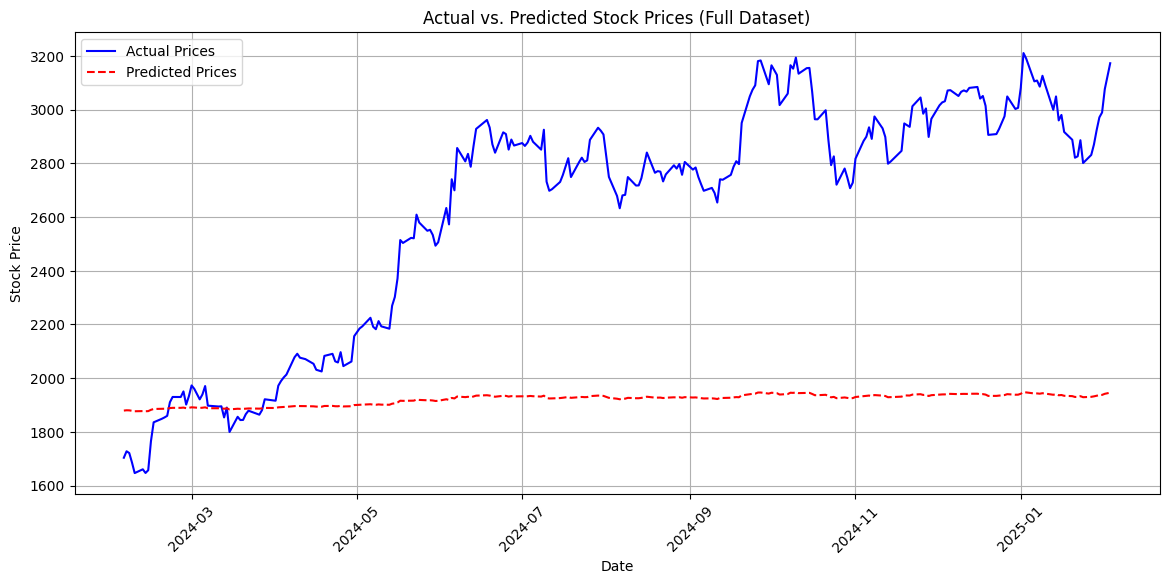

In [53]:
plt.figure(figsize=(14,6))

# Get full dataset predictions
full_data = df['close'].values.reshape(-1, 1)
scaled_predictions = model.predict(full_data.reshape(-1, 1, 1))

# Inverse transform predictions
predicted_prices = scaler.inverse_transform(scaled_predictions)
actual_prices = scaler.inverse_transform(full_data)

# Plot actual vs. predicted
plt.plot(df['Date'], actual_prices, label="Actual Prices", color='blue')
plt.plot(df['Date'], predicted_prices, label="Predicted Prices", linestyle='dashed', color='red')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (Full Dataset)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [55]:
model.save("stock_price_lstm_model.h5")
print("Model saved successfully!")


Model saved successfully!
